# HW2 - Data From The Web

## 1. Web Scraping 

We will first write all functions needed to extract the data from the websites and demonstrate how they work. Then we will complete the assignment using them.

In [1]:
import requests as rq
import matplotlib.pyplot as plt
import numpy as np
from bs4 import BeautifulSoup
import pandas as pd
import seaborn
import pickle
%matplotlib inline
import os.path
from googletrans import Translator
import time


TOP_UNI_URL = 'https://www.topuniversities.com'
TIMES_URL = 'https://www.timeshighereducation.com'

## Helper functions

#### Create dataframe with the scrapped information 

In [2]:
def create_dataframe(data):
    df = pd.DataFrame.from_dict(data).set_index('Rank')
    df = df[['Name', 'Country', 'Region', 'Tot_Stud', 'Inter_Stud', 'Tot_Mem', 'Inter_Mem']]
    return df

#### Calculate Member/Student ratio dataframe

In [3]:
def best_member_student_ratio(df):
    best_ratio = df.copy()
    best_ratio['Members/Students ratio'] =df['Tot_Mem'] / df['Tot_Stud']
    best_ratio = best_ratio.set_index('Name').sort_values(['Members/Students ratio'], ascending=False)
    
    best_ratio[:20]['Members/Students ratio'].plot.bar(title='Top 20 Universities on Member/Student ratio')
    plt.show()
    return best_ratio

#### Calculate International/Student ratio dataframe

In [4]:
def best_international_student_ratio(df):
    best_ratio = df.copy()
    best_ratio['Int_Stud ratio'] = df['Inter_Stud'] / df['Tot_Stud']
    best_ratio = best_ratio.set_index('Name').sort_values(['Int_Stud ratio'], ascending=False)[:20]
    best_ratio[:20]['Int_Stud ratio'].plot.bar(title='Top 20 Universities on Member/Student ratio')
    plt.show()
    return best_ratio

#### Plot ratios by country and region

In [5]:
def plot_ratios_by_country_region(member_student, international_student): 
    plot_country_df_a = member_student.groupby(['Country'])['Members/Students ratio'].mean()
    plot_country_df_a = plot_country_df_a.sort_values(ascending=False)

    plot_country_df_b = international_student.groupby(['Country'])['Int_Stud ratio'].mean()
    plot_country_df_b = plot_country_df_b.sort_values(ascending=False)

    plot_region_df_a = member_student.groupby(['Region'])['Members/Students ratio'].mean()
    plot_region_df_a = plot_region_df_a.sort_values(ascending=False)

    plot_region_df_b = international_student.groupby(['Region'])['Int_Stud ratio'].mean()
    plot_region_df_b = plot_region_df_b.sort_values(ascending=False)



    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.set_figheight(10)
    fig.set_figwidth(15)
    plt.subplots_adjust(hspace = 1)
    plot_country_df_a.plot.bar(ax=axes[0, 0], title='Member/Student ratio by country')
    plot_country_df_b.plot.bar(ax=axes[0, 1], title='International Student ratio by Country')
    plot_region_df_a.plot.bar(ax=axes[1, 0], title='Member/Student ratio by region')
    plot_region_df_b.plot.bar(ax=axes[1, 1], title='International Student ratio by Region')
    plt.show()
    

Here we transform the names of the universities with `cleanName` and we merge the two frames together. We perform an inner join in order to keep only universities that have correspondance in the two data frames

In [6]:
import re

def rreplace(s):
    d = {}
    for w in s.split(): 
        if w.strip(' ') in d.keys(): 
            d[w.strip(' ')]+=1
        else:
             d[w.strip(' ')]=0
    for key, value in d.items():
        li = s.rsplit(key, value)
        s = ''.join(li)
    
    return s.strip()

def cleanName(name):
    to_replace = {'the':'', 'of':'', 'é':'e', '-':' ', '—':' ', '–':' ', '’':'',\
                  '\'':'', '.':'', ',':'', '&':' and ', '(':'', ')':''}
    translator = Translator(service_urls=[
        'translate.google.ch'
    ])
    name = translator.translate(name).text
    name = name.lower()
    #name = re.sub(r"\(.+\)", ' ', name)
    name = rreplace(name)
    
    for key, value in to_replace.items(): 
        name = name.replace(key, value)
    
    name = re.sub(r"\s+", ' ', name)
    name = name.strip(' ')
    print(name)
    
    return name

### 1.1 Top Universities Website

Here are the functions to obtain the amount of faculty members (total & international) and students (total & international)

In [7]:
def get_num_members(soup):
    return int(soup.find('div', class_='total faculty').find('div', class_='number').text.strip().replace(',', '')),\
           int(soup.find('div', class_='inter faculty').find('div', class_='number').text.strip().replace(',', ''))

In [8]:
def get_num_students(soup):
    return int(soup.find('div', class_='total student').find('div', class_='number').text.strip().replace(',', '')),\
           int(soup.find('div', class_='total inter').find('div', class_='number').text.strip().replace(',', ''))

After a quick look with Postman on the webside, we realised that the ranking table data were not given on the page but retrived and added with a script on a json file. We then had to directly get this file to obtain the information we need for this assignment. The file returned by the request is a simple json object with the list of universities ordered by rank after the 'Data' tag.

In [9]:
names = []
g = 0
if not os.path.exists('topunis.pickle'): 
    TOP_WORLD_RANKING_FILE = TOP_UNI_URL + '/sites/default/files/qs-rankings-data/357051.txt'
    ranking_top_uni = rq.get(TOP_WORLD_RANKING_FILE).json().get('data')
    top_unis = []
    for uni in ranking_top_uni[:200]:
        g +=1
        if g % 20 == 0: 
            time.sleep(10)
        name = cleanName(uni.get('title'))
        names.append(name)
        top_unis.append({'Name' : name, 'Rank' : uni.get('rank_display').replace('=', ''), 
                         'Country' : uni.get('country'), 'Region' : uni.get('region'), 'Url' : uni.get('url')})
        
    page = rq.get(TOP_UNI_URL + '/universities/ecole-polytechnique-fédérale-de-lausanne-epfl')
    soup = BeautifulSoup(page.text, 'html.parser')
    tot, inter = get_num_members(soup)
    problematic_uni = []
    for uni in top_unis:
        page = rq.get(TOP_UNI_URL + uni['Url'])
        soup = BeautifulSoup(page.text, 'html.parser')
        try:
            tot_mem, inter_mem = get_num_members(soup)
            tot_stud, inter_stud = get_num_students(soup)
            uni['Tot_Mem'] = tot_mem
            uni['Inter_Mem'] = inter_mem
            uni['Tot_Stud'] = tot_stud
            uni['Inter_Stud'] = inter_stud
        except AttributeError: 
            problematic_uni.append(top_unis.index(uni))
            print('Could not fetch data from:', uni['Name'])
    #Fill in the missing information for "problematic unis"
    nyu = top_unis[problematic_uni[0]]
    nyu['Tot_Mem'] = 7717
    nyu['Inter_Mem'] = 604
    nyu['Tot_Stud'] = 43860
    nyu['Inter_Stud'] = 11593

    bang = top_unis[problematic_uni[1]]
    bang['Tot_Mem'] = 423
    bang['Inter_Mem'] = 0
    bang['Tot_Stud'] = 4071
    bang['Inter_Stud'] = 47
    
    with open('topunis.pickle', 'wb') as out:
        pickle.dump(top_unis, out)
else: 
    with open('topunis.pickle', 'rb') as data: 
        top_unis = pickle.load(data)

massachusetts institute technology mit
stanford university
harvard university
california institute technology caltech
university cambridge
university oxford
ucl university college london
imperial college london
university chicago
eth zurich swiss federal institute technology
nanyang technological university singapore ntu
ecole polytechnique federale de lausanne epfl
princeton university
cornell university
national university singapore nus
yale university
johns hopkins university
columbia university
university pennsylvania
australian national university
university michigan
duke university
university edinburgh
kings college london
tsinghua university
university hong kong
university california berkeley ucb
university tokyo
northwestern university
hong kong university science and technology
university toronto
mcgill university
university california los angeles ucla
university manchester
london school economics and political science lse
kyoto university
seoul national university
peking univ

In [10]:
top_uni_df = create_dataframe(top_unis)
top_uni_df.head()

,Name,Country,Region,Tot_Stud,Inter_Stud,Tot_Mem,Inter_Mem
Rank,,,,,,,
1,massachusetts institute technology mit,United States,North America,11067,3717,2982,1679
2,stanford university,United States,North America,15878,3611,4285,2042
3,harvard university,United States,North America,22429,5266,4350,1311
4,california institute technology caltech,United States,North America,2255,647,953,350
5,university cambridge,United Kingdom,Europe,18770,6699,5490,2278


#### 1.2.a Which are the best universities in terms of ratio between faculty members and students ?
Here are the top 20

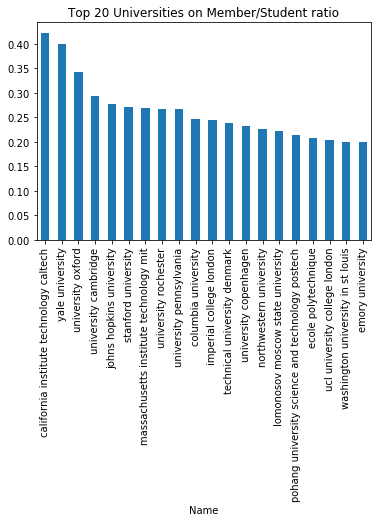

In [12]:
member_student_ratio = best_member_student_ratio(top_uni_df)

#### 1.2.b Which are the best universities in terms of ratio of international students?
Here are the top 20

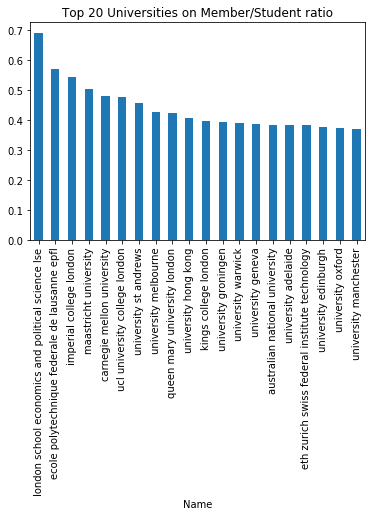

In [13]:
international_student_ratio = best_international_student_ratio(top_uni_df)

#### 1.2.c and 1.2.d Same questions aggregating by country:

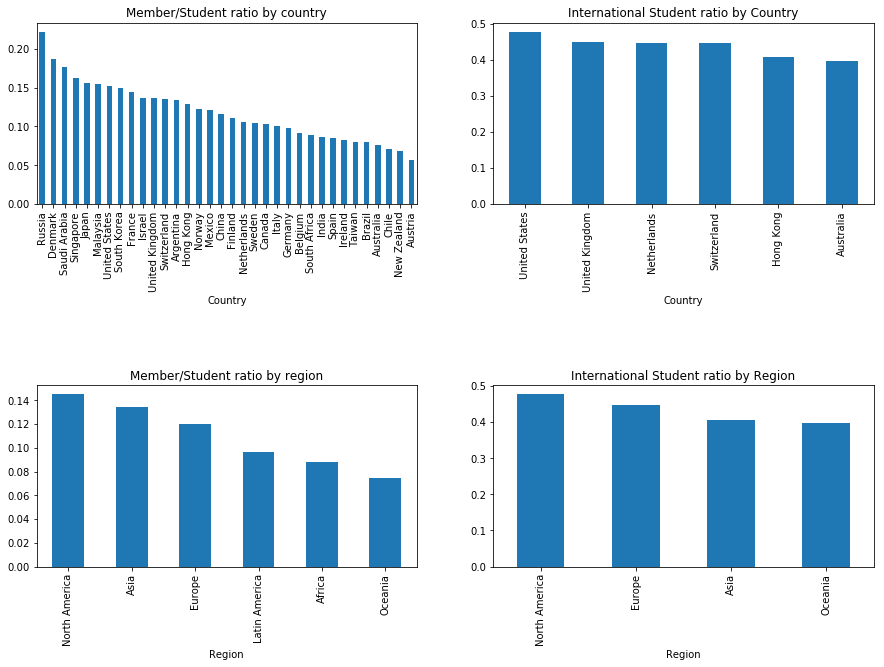

In [14]:
 plot_ratios_by_country_region(member_student_ratio, international_student_ratio)

### 2.1 Times Higher Education Website

The file returned by the request is a simple json object with the list of universities ordered by rank after the 'Data' tag. But this time the *Region* is not given by the website, no even on the specific pages. But this time it contains everything else, no need to scrap the specific pages.

In [19]:
if not os.path.exists('toptimes.pickle'): 
    
    TOP_TIMES_RANKING_FILE = TIMES_URL + '/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'
    ranking_top_times = rq.get(TOP_TIMES_RANKING_FILE).json().get('data')

    top_times = []
    for uni in ranking_top_times[:200]:
        g +=1
        if g % 50 == 0: 
            time.sleep(30)
        name = cleanName(uni.get('name'))
        for n in names: 
            if name in n: 
                name = n
                break
            elif n in name: 
                name = n
                break
        top_times.append({'Name' : name, 'Rank' : uni.get('rank').replace('=', ''), 
                          'Country' : uni.get('location'), 'Region' : None,
                          'Tot_Stud' : int(uni.get('stats_number_students').replace(',', '')), 
                          'Inter_Stud' : round(int(uni.get('stats_number_students').replace(',', '')) * int(uni.get('stats_pc_intl_students').replace('%', '')) / 100),
                          'Tot_Mem' : round(int(uni.get('stats_number_students').replace(',', '')) / float(uni.get('stats_student_staff_ratio'))),
                          'Inter_Mem' : None})
    with open('toptimes.pickle', 'wb') as out:
        pickle.dump(top_times, out)
else: 
    with open('toptimes.pickle', 'rb') as data: 
        top_times = pickle.load(data)
    

university oxford
university cambridge
california institute technology
stanford university
massachusetts institute technology
harvard university
princeton university
imperial college london
university chicago
eth zurich swiss federal institute technology
university pennsylvania
yale university
johns hopkins university
columbia university
university california los angeles
university college london
duke university
university california berkeley
cornell university
northwestern university
university michigan
national university singapore
university toronto
carnegie mellon university
london school economics and political science
university washington
university edinburgh
new york university
peking university
tsinghua university
university california san diego
university melbourne
georgia institute technology
university british columbia
lmu munich
kings college london
university illinois at urbana champaign
federal institute technology in lausanne
karolinska institute
university hong kong
te

In [20]:
top_times_df = create_dataframe(top_times)
top_times_df.head()

,Name,Country,Region,Tot_Stud,Inter_Stud,Tot_Mem,Inter_Mem
Rank,,,,,,,
1,university oxford,United Kingdom,None,20409,7755,1822,None
2,university cambridge,United Kingdom,None,18389,6436,1687,None
3,california institute technology caltech,United States,None,2209,596,340,None
3,stanford university,United States,None,15845,3486,2113,None
5,massachusetts institute technology mit,United States,None,11177,3800,1285,None


### Fill in the regions for the top times dataframe from top uni dataframe

To do this task we take the unique $country->region$ mappings from the first ranking. We can see that in the Top Universities ranking Luxembourg doesn't appear, so we have to map it by hand. Also Russia appears as `Russia` in the Top Universities ranking and as `Russian Federation` in the Top Times rankings. We also map it separately to have Europe as region. 

In [21]:
df = top_uni_df[['Country', 'Region']].groupby(['Country','Region'])

country_region = {}
for country, region in df.groups.keys(): 
    top_times_df.loc[top_times_df['Country'] == country, 'Region'] = region
    
top_times_df.loc[top_times_df['Country'] == 'Luxembourg', 'Region'] = 'Europe'
top_times_df.loc[top_times_df['Country'] == 'Russian Federation', 'Region'] = 'Europe'

top_times_df.head()

,Name,Country,Region,Tot_Stud,Inter_Stud,Tot_Mem,Inter_Mem
Rank,,,,,,,
1,university oxford,United Kingdom,Europe,20409,7755,1822,None
2,university cambridge,United Kingdom,Europe,18389,6436,1687,None
3,california institute technology caltech,United States,North America,2209,596,340,None
3,stanford university,United States,North America,15845,3486,2113,None
5,massachusetts institute technology mit,United States,North America,11177,3800,1285,None


#### 2.2.a Which are the best universities in terms of ratio between faculty members and students ?
Here are the top 20

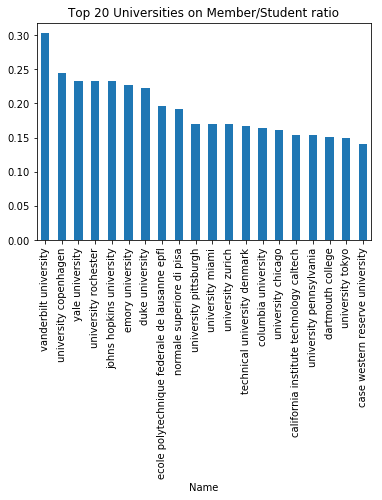

In [22]:
member_student_ratio = best_member_student_ratio(top_times_df)

#### 2.2.b Which are the best universities in terms of ratio of international students?
Here are the top 20

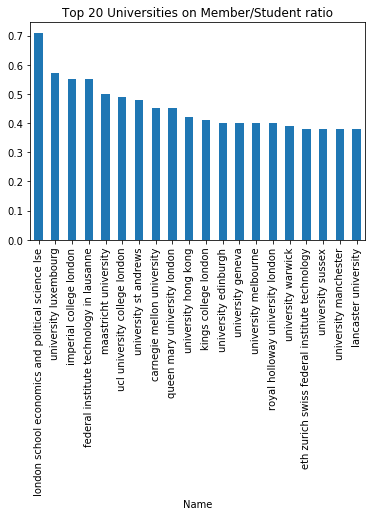

In [23]:
international_student_ratio = best_international_student_ratio(top_times_df)

#### 2.2.c and 2.2.d Same questions aggregating by country and region

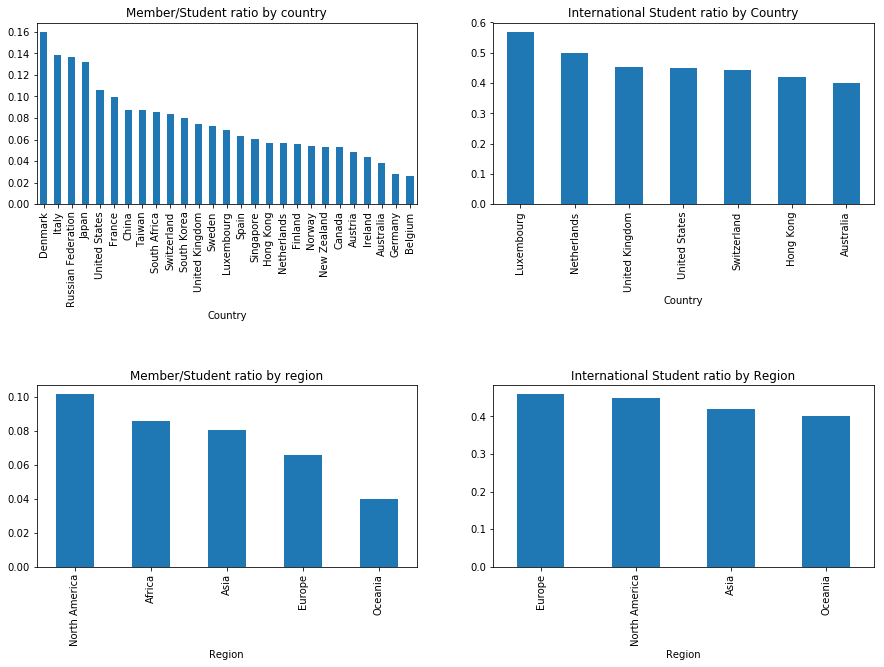

In [24]:
 plot_ratios_by_country_region(member_student_ratio, international_student_ratio)

### 3. Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

This function prepare the names for the merge. We noticed that in one of the rankings the name is present as well as an abreviation of the university name. For exemple "Ecole polytechnique federale de lausanne (EPFL)" and in the othe rankng the abreviation was not present. Because of that we remove all abreviations of that type. We also remove some types of ponctuation and blank spaces.  

In [25]:
merged_df = top_times_df.reset_index().merge(top_uni_df.reset_index(), on=['Name'], suffixes=('_Times', '_Unis'), how='inner')
merged_df.head()
merged_df

,Rank_Times,Name,Country_Times,Region_Times,Tot_Stud_Times,Inter_Stud_Times,Tot_Mem_Times,Inter_Mem_Times,Rank_Unis,Country_Unis,Region_Unis,Tot_Stud_Unis,Inter_Stud_Unis,Tot_Mem_Unis,Inter_Mem_Unis
0,1,university oxford,United Kingdom,Europe,20409,7755,1822,None,6,United Kingdom,Europe,19720,7353,6750,2964
1,2,university cambridge,United Kingdom,Europe,18389,6436,1687,None,5,United Kingdom,Europe,18770,6699,5490,2278
2,3,california institute technology caltech,United States,North America,2209,596,340,None,4,United States,North America,2255,647,953,350
3,3,stanford university,United States,North America,15845,3486,2113,None,2,United States,North America,15878,3611,4285,2042
4,5,massachusetts institute technology mit,United States,North America,11177,3800,1285,None,1,United States,North America,11067,3717,2982,1679
5,6,harvard university,United States,North America,20326,5285,2284,None,3,United States,North America,22429,5266,4350,1311
6,7,princeton university,United States,North America,7955,1909,958,None,13,United States,North America,8069,1793,1007,246
7,8,imperial college london,United Kingdom,Europe,15857,8721,1391,None,8,United Kingdom,Europe,16090,8746,3930,2071
8,9,university chicago,United States,North America,13525,3381,2181,None,9,United States,North America,13557,3379,2449,635
9,10,eth zurich swiss federal institute technology,Switzerland,Europe,19233,7309,1317,None,10,Switzerland,Europe,19815,7563,2477,1886


### 4. Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?